In [1]:
from __future__ import print_function
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import random
import os
import argparse
import numpy as np
from Models import *
from torchvision.models import vgg19_bn

from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt

import data_loader_cifar as dataloader

import time
import datetime
import gc

#40 asym, 0.04 xi, eta 10, nc 20, nv 40

In [2]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR Training')
parser.add_argument('--batch_size', default=64, type=int, help='train batchsize') 
parser.add_argument('--lr', '--learning_rate', default=0.02, type=float, help='initial learning rate')
parser.add_argument('--noise_mode',  default='sym_0.5', help = 'aggre,worst,rand1,rand2,rand3,noisy100, or sym_0.x, asym_0.x')
parser.add_argument('--num_epochs', default=300, type=int)
parser.add_argument('--t_w', default=10, type=int)
parser.add_argument('--nR', default=0.04, type=float)
parser.add_argument('--nc', default=0.2, type=float)
parser.add_argument('--nv', default=0.8, type=float)
parser.add_argument('--nvs', default=0.1, type=float)
parser.add_argument('--id', default='')
parser.add_argument('--seed', default=123)
parser.add_argument('--gpuid', default=0, type=int)
parser.add_argument('--data_path', default='./cifar-10', type=str, help='path to dataset')
parser.add_argument('--dataset', default='cifar10', type=str)
args = parser.parse_args(args = ['--data_path', 'data/CIFAR100',
                                 '--dataset', 'cifar100',
                                 '--noise_mode','asym_0.4',
                                 '--t_w', '30',
                                 '--batch_size','64',
                                 '--lr','0.02',
                                 '--num_epochs','31',
                                 '--nR', '0.1',
                                 '--nc','0.10',
                                 '--nv','0.2',
                                 '--nvs','0.02'])

In [3]:
torch.cuda.set_device(args.gpuid)
random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

In [4]:
samples = 50000
test_samples = 10000
if args.dataset == 'cifar10':
    n_class = 10
else:
    n_class = 100
feature_num = 512
t_w = args.t_w

In [5]:
def test(epoch,net,):
    net.eval()
    correct = 0
    total = 0
    feature_temp = np.zeros((test_samples, feature_num))
    with torch.no_grad():
        for batch_idx, (inputs, targets, ind) in enumerate(test_loader):
            ind = ind.numpy()
            inputs, targets = inputs.cuda(), targets.cuda()
            feature, output = net(inputs)       
            _, predicted = torch.max(output, 1)     
            
            feature_temp[ind] = feature.cpu().detach().numpy()
                       
            total += targets.size(0)
            correct += predicted.eq(targets).cpu().sum().item()                 
    acc = 100.*correct/total
    
    test_log.write('Epoch:%d   Accuracy:%.2f\n'%(epoch,acc))
    test_log.flush()  
    
    lossb = relevant_hard_np(feature_temp)
    return acc, lossb, feature_temp


def linear_rampup(current, warm_up, rampup_length=16):
    current = np.clip((current-warm_up) / rampup_length, 0.0, 1.0)
    return args.lambda_u*float(current)


class NegEntropy(object):
    def __call__(self,outputs):
        probs = torch.softmax(outputs, dim=1)
        return torch.mean(torch.sum(probs.log()*probs, dim=1))
    

class Orthogonal_loss(nn.Module):
    def __init__(self,):
        super(Orthogonal_loss, self).__init__()
        
    def forward(self, x, ):
        n = x.size(0)
        m = x.size(1)

        I = torch.eye(m).cuda()
        e = x - x.mean(dim=0, keepdims = True)
        m_nonz = (e.sum(dim = 0) != 0).sum()
        
        cov = e.T @ e
        
        cov2 = cov ** 2
        
        select_i = torch.argmax(cov2 - cov2 * I, dim = 1)
        cov_m = (F.one_hot(select_i, num_classes = m) * cov2).sum()
        cov_i = (I * cov).sum()
        
        result = (cov_m-cov_i) / (m_nonz * n)
        return result
    
def relevant_hard_np(x,):
    n = x.shape[0]
    nz = x.shape[1]
    e = x - x.mean(axis = 0,keepdims = True)

    cov = e.T @ e

    sigma = (e ** 2).sum(axis = 0, keepdims = True)
    r = cov / (sigma.T @ sigma) ** 0.5

    r = r ** 2
    r[np.isnan(r)] = 0.0

    return np.mean(np.max(r - r * np.eye(nz), axis = -1))
    
class MSELoss(object):
    def __call__(self, logits, targets,):
        if len(targets.shape) == 1:
            targets = F.one_hot(targets, num_classes=n_class)
        
        probs = torch.softmax(logits, dim=1)

        Lu = torch.mean((probs - targets)**2, dim = -1)

        return Lu
    
def create_model():
    model = ResNet18(num_classes=n_class)
    model = model.cuda()
    return model

In [6]:
stats_log=open('./checkpoint/SNRLNL_%s_%s_%s'%(
    args.dataset,args.noise_mode,str(datetime.date.today())+'_'+str(time.localtime().tm_hour))+'_stats.txt','w') 
test_log=open('./checkpoint/SNRLNL_%s_%s_%s'%(
    args.dataset,args.noise_mode,str(datetime.date.today())+'_'+str(time.localtime().tm_hour))+'_acc.txt','w')     

In [7]:
real_world_noise_types = ['aggre','worst','rand1','rand2','rand3','noisy100']
synthetic_noise_types = ['sym','asym']

In [8]:
if args.noise_mode in real_world_noise_types:
    if args.dataset == 'cifar10':
        loader = dataloader.cifar_dataloader(args.dataset,noise_mode=args.noise_mode,batch_size=args.batch_size,num_workers=5,\
            root_dir=args.data_path,log=stats_log,noise_file='%s/CIFAR-10_human.pt'%(args.data_path,))
    else:
        loader = dataloader.cifar_dataloader(args.dataset,noise_mode=args.noise_mode,batch_size=args.batch_size,num_workers=5,\
            root_dir=args.data_path,log=stats_log,noise_file='%s/CIFAR-100_human.pt'%(args.data_path,))
else:
    loader = dataloader.cifar_dataloader(args.dataset,noise_mode=args.noise_mode,batch_size=args.batch_size,num_workers=5,\
        root_dir=args.data_path,log=stats_log,noise_file='%s/%s.json'%(args.data_path,args.noise_mode))

print('| Building net')
net = create_model()
cudnn.benchmark = True

opt = optim.SGD(net.parameters(),
                lr=args.lr,
                momentum=0.9,
                weight_decay=5e-4
               )

sch = optim.lr_scheduler.MultiStepLR(opt, [50, 100,], gamma = 0.1)

CE = nn.CrossEntropyLoss(reduction='none')
CEloss = nn.CrossEntropyLoss()
MSE = MSELoss()

loss_ortho = Orthogonal_loss()

all_loss = [[],[]] # save the history of losses from two networks

traindataset, trainloader = loader.run('warmup')
testdataset, test_loader = loader.run('test')

| Building net


In [9]:
train_Y = np.array(traindataset.train_label)
test_Y = np.array(testdataset.test_label)
noisy_Y = np.array(traindataset.noise_label)
revised_Y = np.array(traindataset.noise_label)
revised_Y_before = np.array(traindataset.noise_label)

Yt_list = []
feature_list = []

acc_list = []
loss_sep_list = [[]]
loss_train_list = []
Py_temp_list = []
Pm_other_list = []

Logits_other_m_list = []
Logits_y_list = []

learning_risk_list = []

score = np.random.rand(samples,)
score_uncertainty = np.random.rand(samples,)

OOD_mask_before = np.zeros((samples,),np.bool)

start_time = time.time()

for epoch in range(args.num_epochs):
    
    net.train()
    feature_num = 512
    if epoch < t_w:
        _, trainloader = loader.run('warmup')
    else:
        _, trainloader = loader.run('train')

    loss_train = 0
    acc_train = 0
    acc_train_ori = 0
    loss_train_ori = 0
    Py_temp = np.zeros((samples,),dtype=np.float32)
    Pm_other_temp = np.zeros((samples,),dtype=np.float32)
    
    Logits_other_m_temp = np.zeros((samples,),dtype=np.float32)
    Logits_y_temp = np.zeros((samples,),dtype=np.float32)
    
    Pred_temp = np.zeros((samples,),dtype=np.float32)
    Probs_temp = np.zeros((samples,n_class),dtype=np.float32)
    Logits_temp = np.zeros((samples,n_class),dtype=np.float32)
    Pred_other_temp = np.zeros((samples,),dtype=np.float32)
    
    feature_temp = np.zeros((samples, feature_num), dtype = np.float32)

    if len(Py_temp_list) > 1:
        score = Py_temp_list[-1]
    else:
        score = np.random.rand(samples,)
        
    OOD_mask = np.logical_and(score < np.sort(score[~OOD_mask_before])[int(len(score[~OOD_mask_before]) * args.nR)], ~OOD_mask_before)
    
    Y_onehot = np.eye(n_class)[revised_Y].astype(np.float32)
    Y_onehot_0 = np.eye(n_class)[noisy_Y].astype(np.float32)
    
    for batch_id, (X_data, targets, ind) in enumerate(trainloader):
        ind = ind.numpy()

        Y_data = np.array(revised_Y[ind]).astype(np.int64)
        Y_data_ori = np.array(train_Y[ind]).astype(np.int64)
        Y_data_before = np.array(revised_Y_before[ind]).astype(np.int64)
        temp_X = X_data.cuda()
        opt.zero_grad()
        Y_GPU = torch.from_numpy(Y_data).cuda()
        Y_GPU_ori = torch.from_numpy(Y_data_ori).cuda()
        Y_GPU_before = torch.from_numpy(Y_data_before).cuda()
        
        y_onehot = F.one_hot(Y_GPU.view(-1,),num_classes=n_class)
        y_onehot_before = F.one_hot(Y_GPU_before.view(-1,),num_classes=n_class)
        
        feature, logits = net(temp_X)

        probs = logits.softmax(1)
        Py = torch.sum(y_onehot * probs, dim = -1)
        Pred = probs.argmax(-1)
        Pm_other, _ = torch.max(probs - probs * y_onehot_before, dim = 1)
        Logits_other_m, _ = torch.max(logits - logits * y_onehot_before, dim = 1)
        Logits_y = torch.sum(logits * y_onehot_before, dim = 1)
        
        logits_other = logits - logits * y_onehot_before
        Pred_other = torch.argmax(logits_other,dim=-1)
        
        if epoch < args.t_w:
            loss = CEloss(logits,Y_GPU.view(-1,))
        else:
            Y_GPU = torch.where(torch.from_numpy(OOD_mask[ind]).cuda(), Pred_other, Y_GPU)
            loss = CEloss(logits,Y_GPU.view(-1,))
            
        Py_temp[ind] = Py.cpu().detach().numpy()
        Pred_temp[ind] = Pred.cpu().detach().numpy()
        Pm_other_temp[ind] = Pm_other.cpu().detach().numpy()

        Logits_other_m_temp[ind] = Logits_other_m.cpu().detach().numpy()
        Logits_y_temp[ind] = Logits_y.cpu().detach().numpy()
        
        
        Probs_temp[ind] = probs.cpu().detach().numpy()
        Logits_temp[ind] = logits.cpu().detach().numpy()
        feature_temp[ind] = feature.cpu().detach().numpy()
        
        Pred_other_temp[ind] = Pred_other.cpu().detach().numpy()
                
        correct = (Pred == Y_GPU).sum().item()
        correct_ori = (Pred == Y_GPU_ori).sum().item()

        loss_train += loss.item()
        acc_train += correct
        acc_train_ori += correct_ori
        
        loss_sep_list[-1].append(loss.item())
        
        loss.backward()
        
        opt.step()
    sch.step()
    
    loss_train/=(batch_id+1)
    acc_train/=samples
    acc_train_ori/=samples

    print('epoch %d train complete'%epoch)
    acc_eval, lossb_eval, feature_val = test(epoch, net)
    
    loss_b = relevant_hard_np(feature_temp[:10000])

    acc_list.append(acc_eval)
    Py_temp_list.append(Py_temp)
    Pm_other_list.append(Pm_other_temp)

    Logits_other_m_list.append(Logits_other_m_temp)
    Logits_y_list.append(Logits_y_temp)
    
    revised_Y_before = revised_Y.copy()
    OOD_mask_before = OOD_mask.copy()    
        
    if epoch < t_w:
        select = np.zeros((samples,),dtype = np.bool)
        learning_risk = np.random.rand(samples,)
    else:
        nC_points = []
        clean_mask = np.zeros((samples,),dtype=bool)
        Py_mean = np.zeros((samples,))
        for j in range(len(Py_temp_list)):
            Py_mean+=Py_temp_list[j]
        Py_mean/=len(Py_temp_list)   
        for j in range(n_class):
            class_mask = noisy_Y == j
            c_n = class_mask.sum()
            c_th = np.sort(Py_mean[class_mask])[-int(c_n * args.nc)]
            nC_points.append(np.where(np.logical_and(Py_mean>=c_th,class_mask))[0])
        nC_points = np.concatenate(nC_points)
        L_batch = 1000
        Y_onehot = np.eye(n_class)[revised_Y]
        zC = torch.from_numpy(feature_temp[nC_points].astype(np.float32)).cuda()
        fC = torch.from_numpy(Probs_temp[nC_points].astype(np.float32)).cuda()
        yC = torch.from_numpy(Y_onehot[nC_points].astype(np.float32)).cuda()
        fCcyC = fC - yC
        lr = 1e-6
        learning_risk = np.zeros((samples,)) 
        for j in range(int(np.ceil(samples/L_batch))):
            i_ind = np.arange(j*L_batch, min(samples,(j+1)*L_batch))
            zi = torch.from_numpy(feature_temp[i_ind].astype(np.float32)).cuda()
            fi = torch.from_numpy(Probs_temp[i_ind].astype(np.float32)).cuda()
            yi = torch.from_numpy(Y_onehot[i_ind].astype(np.float32)).cuda()
            zixzC = zi @ zC.transpose(1,0)
            part_1_1 = (zixzC + 1) @ fCcyC
            part1 = (part_1_1 * (yi-fi)).sum(dim=-1,keepdim=True)*4*lr/len(nC_points)
            part1_all = part_1_1 * (fi-torch.ones_like(yi))*4*lr/len(nC_points)

            learning_risk[i_ind] = part1.cpu().detach().numpy().ravel()
        # r_ = min(0.1 + 0.1 * (epoch - t_w), args.nv)
        r_ = min(args.nvs + args.nvs * (epoch - t_w), args.nv)
        select = np.zeros((samples,),dtype=np.bool8)
        for j in range(n_class):
            class_mask = revised_Y == j
            c_n = class_mask.sum()
            c_th = np.sort(learning_risk[class_mask])[-min(int(c_n * r_),c_n)]
            select[np.logical_and(learning_risk>=c_th, class_mask)] = True
        # th = np.sort(learning_risk)[-min(int(samples * r_),samples)]
        # select = learning_risk >= th
        
        revised_Y=np.where(select.ravel(), Pred_temp.ravel(), noisy_Y.ravel()).astype(int)

    is_noise = revised_Y != train_Y
    max_noised_class = -999
    for j_ in range(n_class):
        class_mask = train_Y == j_
        noise_n = np.logical_and(class_mask, is_noise).sum()
        if noise_n > max_noised_class:
            max_noised_class = noise_n
    

    Yt_remain_noise = np.sum(is_noise)
    end_time = time.time()
    print_str = 'loss_b:%.4f, loss_b_eval:%.4f, train loss:%.4f, train acc:%.4f, train acc ori:%.4f,\
          eval acc:%.4f, time elapsed:%.4f, epoch %d train cleaned, %d samples changed,\
          total remain noise:%.4d, max class noise:%d'%(loss_b,
                                                        lossb_eval,
                                                        loss_train,
                                                        acc_train,
                                                        acc_train_ori, 
                                                        acc_eval,
                                                        end_time - start_time,
                                                        epoch,
                                                        np.sum(revised_Y!=noisy_Y),
                                                        Yt_remain_noise,
                                                        max_noised_class)
    print(print_str)
    stats_log.write(print_str+'\n')
    stats_log.flush()  
    # loss_sep_list.append([])
    learning_risk_list.append(learning_risk)
    Yt_list.append(revised_Y)
    if epoch % 5 == 0:
        feature_list.append(feature_temp)
    else:
        feature_list.append(None)
    
    gc.collect()

/tmp/ipykernel_89002/516161497.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  OOD_mask_before = np.zeros((samples,),np.bool)


epoch 0 train complete


/tmp/ipykernel_89002/516161497.py:145: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  select = np.zeros((samples,),dtype = np.bool)


loss_b:0.4694, loss_b_eval:0.6098, train loss:4.2088, train acc:0.0575, train acc ori:0.0710,          eval acc:11.4500, time elapsed:15.6290, epoch 0 train cleaned, 0 samples changed,          total remain noise:20021, max class noise:227
epoch 1 train complete
loss_b:0.4787, loss_b_eval:0.5245, train loss:3.8074, train acc:0.1042, train acc ori:0.1341,          eval acc:15.4400, time elapsed:30.9040, epoch 1 train cleaned, 0 samples changed,          total remain noise:20021, max class noise:227
epoch 2 train complete
loss_b:0.4391, loss_b_eval:0.5066, train loss:3.4779, train acc:0.1465, train acc ori:0.1886,          eval acc:21.3400, time elapsed:46.2468, epoch 2 train cleaned, 0 samples changed,          total remain noise:20021, max class noise:227
epoch 3 train complete
loss_b:0.4259, loss_b_eval:0.4522, train loss:3.1510, train acc:0.1878, train acc ori:0.2393,          eval acc:24.8100, time elapsed:62.7696, epoch 3 train cleaned, 0 samples changed,          total remain nois

In [10]:
max(acc_list)

45.38

In [11]:
# Py_mean_10 = np.zeros((samples,))
# for Py in Py_temp_list:
#     Py_mean_10 = Py_mean_10 + Py
# Py_mean_10/=len(Py_temp_list)
# np.save('Py_mean_10.npy',Py_mean_10)

In [12]:
# Py_mean_100 = np.zeros((samples,))
# for Py in Py_temp_list:
#     Py_mean_100 = Py_mean_100 + Py
# Py_mean_100/=len(Py_temp_list)
# np.save('Py_mean_100.npy',Py_mean_100)

In [13]:
#tw  0, sym 20,40,60,80: 92.45,90.79,87.65,74.05
#tw 10, sym 20,40,60,80: 92.76,90.81,87.55,75.20
#tw 20, sym 20,40,60,80: 92.36,90.65,87.19,75.77
#tw 30, sym 20,40,60,80: 92.04,90.46,86.12,75.59

In [14]:
#nc   5, sym 20,40,60,80: 92.67,90.99,87.48,76.17
#nc  10, sym 20,40,60,80: 92.61,91.13,87.33,74.83
#nc  20, sym 20,40,60,80: 92.75,90.82,87.30,74.68
#nc  40, sym 20,40,60,80: 92.82,91.01,87.54,77.14

In [15]:
#nv  10, sym 20,40,60,80: 92.50,89.72,84.68,73.90
#nv  20, sym 20,40,60,80: 92.49,91.15,87.33,74.51
#nv  40, sym 20,40,60,80: 92.50,90.90,87.79,77.96
#nv  80, sym 20,40,60,80: 92.79,91.05,87.01,63.24

In [16]:
#nr   2, sym 20,40,60,80: 92.98,91.01,87.54,74.45
#nr   5, sym 20,40,60,80: 92.84,91.05,88.05,74.81
#nr  10, sym 20,40,60,80: 92.52,90.93,87.26,75.33
#nr  20, sym 20,40,60,80: 89.94,90.98,87.63,75.79

In [11]:
tsne = TSNE()

Py_mean_clean = np.load('Py_mean_100.npy')
# Py_mean_clean = np.load('Py_mean_10.npy')

log_list = []
for Py in Py_temp_list:
    log_list.append(-np.log(Py))

hard_mask = np.zeros((samples,),dtype = np.bool)
temp_mask = np.zeros((samples,),dtype = np.bool)
for j in range(n_class):
    c_m = train_Y == j
    c_n = c_m.sum()
    c_th = np.sort(Py_mean_clean[c_m])[int(c_n * 0.1)]
    hard_mask[np.logical_and(c_m, Py_mean_clean < c_th)] = True
    
    
class_mask = np.logical_or(np.logical_or(train_Y == 4, train_Y == 2), train_Y == 3)

/tmp/ipykernel_89002/1566262679.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hard_mask = np.zeros((samples,),dtype = np.bool)
/tmp/ipykernel_89002/1566262679.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp_mask = np.zeros((samples,),dtype = np.bool)


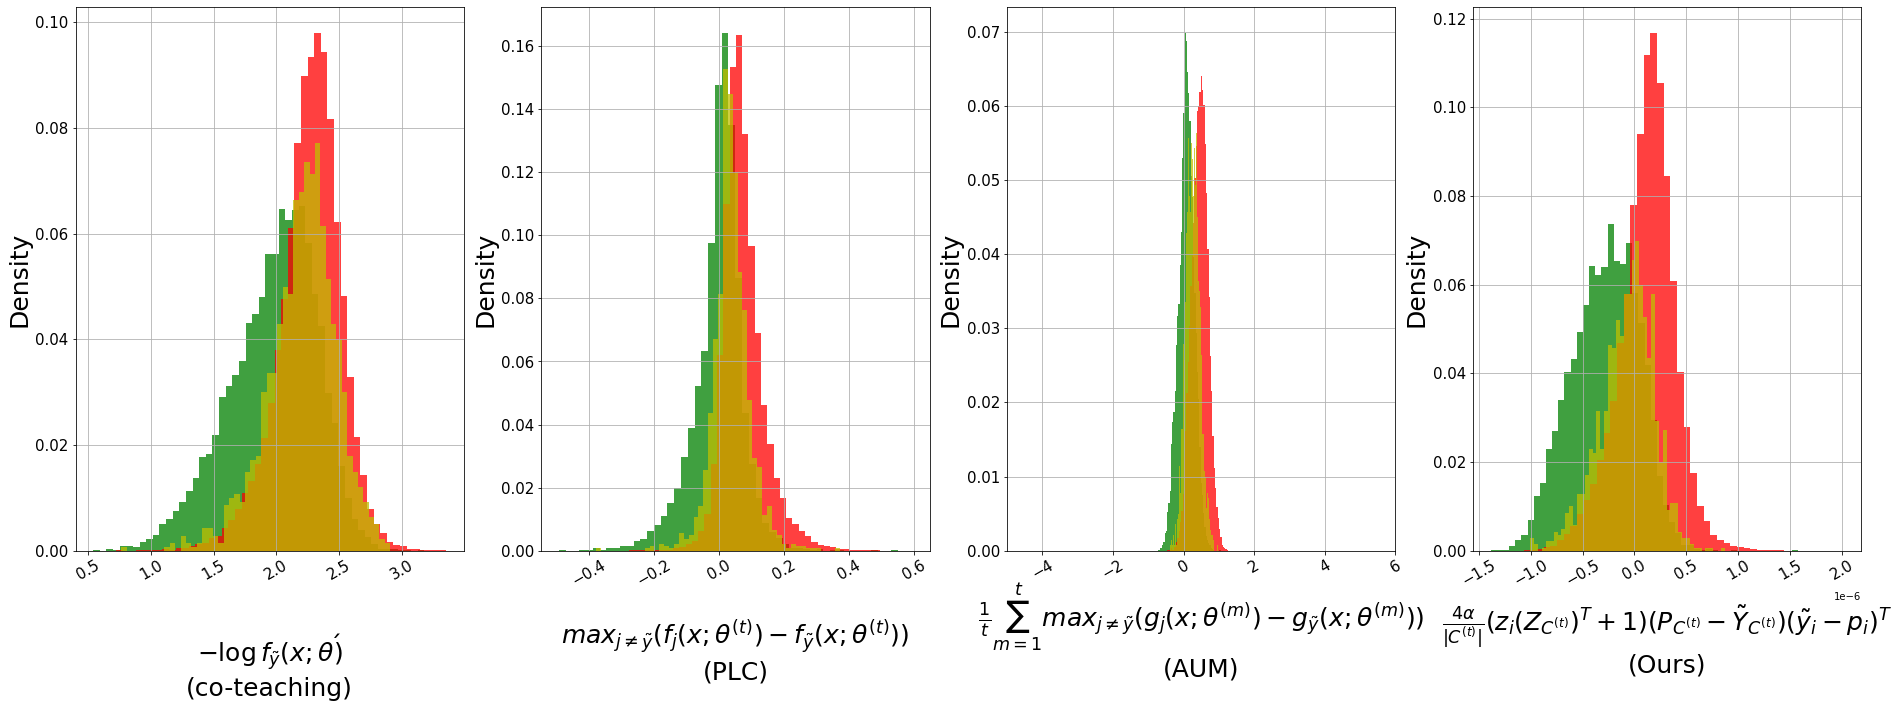

In [21]:
# i = 10

# is_noise_mask = Yt_list[0]!=train_Y
# hard_clean_mask = np.logical_and(hard_mask,~is_noise_mask)
# standard_mask = ~np.logical_or(is_noise_mask,hard_mask)

# n_n = float(is_noise_mask.sum())
# h_n = float(hard_clean_mask.sum())
# s_n = float(standard_mask.sum())

# plt.figure(figsize=(32,10))

# plt.subplot(1,4,1)
# L_1 = -np.log(Py_temp_list[i])
# plt.hist(L_1[standard_mask],50, label = 'simple clean samples',color='g',alpha=0.75,
# weights=np.ones_like(L_1[standard_mask])/s_n)
# plt.hist(L_1[is_noise_mask]*0.95,50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_1[is_noise_mask])/n_n)
# plt.hist(L_1[hard_clean_mask],50, label = 'hard clean samples',color='y',alpha=0.75,
# weights=np.ones_like(L_1[hard_clean_mask])/h_n)

# plt.xlabel(r'$-\log{f_{\tilde{y}}(x;\theta\')}$'+'\n(co-teaching)',
# fontsize = 25,labelpad = 50)
# # plt.xlim([-5,6])
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)

# # plt.xlim([-0.00025,0.001])
# plt.subplot(1,4,2)
# L_2 = Pm_other_list[i]-Py_temp_list[i]
# plt.hist(L_2[standard_mask],50, label = 'simple clean samples',color = 'g',alpha=0.75,
# weights=np.ones_like(L_2[standard_mask])/s_n)
# plt.hist(L_2[is_noise_mask],50, label = 'noisy samples',color = 'r',alpha=0.75,
# weights=np.ones_like(L_2[is_noise_mask])/n_n)
# plt.hist(L_2[hard_clean_mask],50, label = 'hard clean samples',color = 'y',alpha=0.75,
# weights=np.ones_like(L_2[hard_clean_mask])/h_n)

# plt.xlabel(r'$max_{j \neq \tilde{y}} (f_{j}(x;\theta^{(t)}) - f_{\tilde{y}}(x;\theta^{(t)}))$'+'\n(PLC)',
# fontsize = 25,labelpad = 30)
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False,loc=2)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)

# plt.subplot(1,4,3)
# L_3 = np.zeros((samples,))
# for i_ in range(i):
#     L_3 = L_3 + Logits_other_m_list[i_] - Logits_y_list[i_]
# L_3 /= i
# plt.hist(L_3[standard_mask],50, label = 'simple clean samples',color='g',alpha=0.75,
# weights=np.ones_like(L_3[standard_mask])/s_n)
# plt.hist(L_3[is_noise_mask]*1,50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_3[is_noise_mask])/n_n)
# plt.hist(L_3[hard_clean_mask],50, label = 'hard clean samples',color='y',alpha=0.75,
# weights=np.ones_like(L_3[hard_clean_mask])/h_n)

# plt.xlabel(r'$\frac{1}{t}\sum^t_{m=1}{max_{j \neq \tilde{y}} (g_{j}(x;\theta^{(m)})-g_{\tilde{y}}(x;\theta^{(m)}))}$'+'\n(AUM)',
# fontsize = 25,labelpad = -0)
# plt.xlim([-5,6])
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)


# plt.subplot(1,4,4)
# L_4 = learning_risk_list[i]
# plt.hist(L_4[standard_mask],50, label = 'simple clean samples',color = 'g',alpha=0.75,
# weights=np.ones_like(L_4[standard_mask])/s_n)
# plt.hist(L_4[is_noise_mask],50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_4[is_noise_mask])/n_n)
# plt.hist(L_4[hard_clean_mask],50, label = 'hard clean samples',color='y', alpha=0.75,
# weights=np.ones_like(L_4[hard_clean_mask])/h_n)

# plt.xlabel(r'$\frac{4\alpha}{|C^{(t)}|}(z_i(Z_{C^{(t)}})^T+1)(P_{C^{(t)}}-\tilde{Y}_{C^{(t)}})(\tilde{y}_i-p_i)^T$'+'\n(Ours)',
# fontsize = 25,labelpad = 15)
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# # plt.ticklabel_format(style='plain',)
# plt.yticks(fontsize = 15)
# plt.ticklabel_format(style='sci',axis='x',scilimits = (0,0))
# plt.xticks(fontsize = 15,rotation = 30)

# plt.savefig('Learning_risk_compare_10_uniform.png',dpi = 200, bbox_inches = 'tight')
# plt.savefig('Learning_risk_compare_10_uniform.pdf',dpi = 200, bbox_inches = 'tight')
# plt.show()

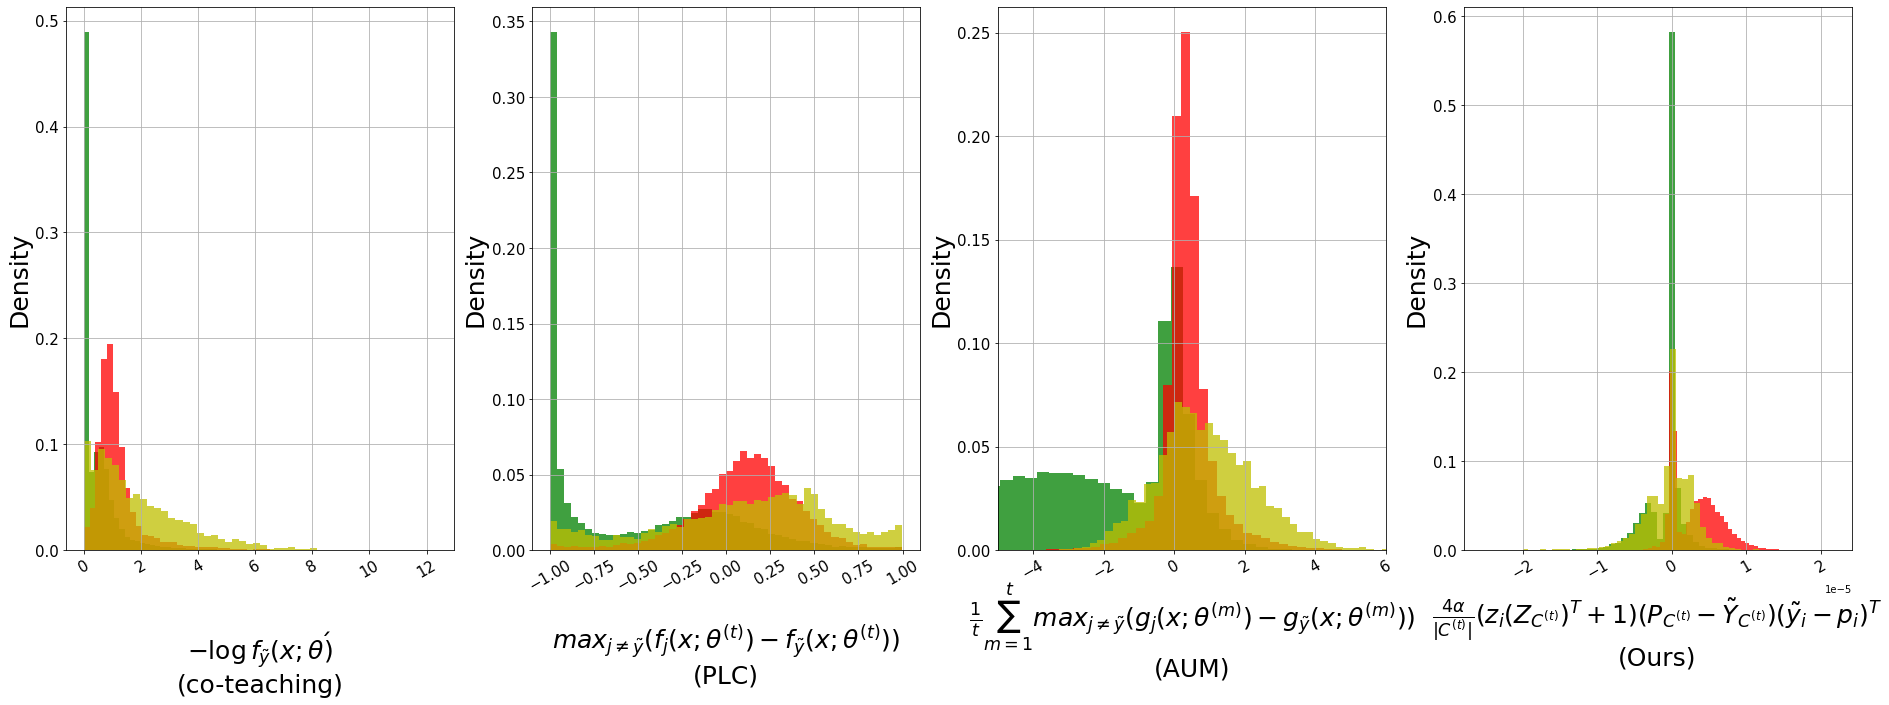

In [17]:
# i = 10

# is_noise_mask = Yt_list[0]!=train_Y
# hard_clean_mask = np.logical_and(hard_mask,~is_noise_mask)
# standard_mask = ~np.logical_or(is_noise_mask,hard_mask)

# rand_mask = np.random.rand(samples)<0.3

# n_n = float(is_noise_mask.sum())
# h_n = float(hard_clean_mask.sum())
# s_n = float(standard_mask.sum())

# plt.figure(figsize=(32,10))

# plt.subplot(1,4,1)
# L_1 = -np.log(Py_temp_list[i])
# plt.hist(L_1[standard_mask],50, label = 'simple clean samples',color='g',alpha=0.75,
# weights=np.ones_like(L_1[standard_mask])/s_n)
# plt.hist(L_1[is_noise_mask],50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_1[is_noise_mask])/n_n)
# plt.hist(L_1[hard_clean_mask],50, label = 'hard clean samples',color='y',alpha=0.75,
# weights=np.ones_like(L_1[hard_clean_mask])/h_n)

# plt.xlabel(r'$-\log{f_{\tilde{y}}(x;\theta\')}$'+'\n(co-teaching)',
# fontsize = 25,labelpad = 50)
# # plt.xlim([-5,6])
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)

# # plt.xlim([-0.00025,0.001])
# plt.subplot(1,4,2)
# L_2 = Pm_other_list[i]-Py_temp_list[i]
# plt.hist(L_2[standard_mask],50, label = 'simple clean samples',color = 'g',alpha=0.75,
# weights=np.ones_like(L_2[standard_mask])/s_n)
# plt.hist(L_2[is_noise_mask],50, label = 'noisy samples',color = 'r',alpha=0.75,
# weights=np.ones_like(L_2[is_noise_mask])/n_n)
# plt.hist(L_2[hard_clean_mask],50, label = 'hard clean samples',color = 'y',alpha=0.75,
# weights=np.ones_like(L_2[hard_clean_mask])/h_n)

# plt.xlabel(r'$max_{j \neq \tilde{y}} (f_{j}(x;\theta^{(t)}) - f_{\tilde{y}}(x;\theta^{(t)}))$'+'\n(PLC)',
# fontsize = 25,labelpad = 30)
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False,loc=2)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)

# plt.subplot(1,4,3)
# L_3 = np.zeros((samples,))
# for i_ in range(i):
#     L_3 = L_3 + Logits_other_m_list[i_] - Logits_y_list[i_]
# L_3 /= i
# plt.hist(L_3[standard_mask],50, label = 'simple clean samples',color='g',alpha=0.75,
# weights=np.ones_like(L_3[standard_mask])/s_n)
# plt.hist(L_3[is_noise_mask]*1,50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_3[is_noise_mask])/n_n)
# plt.hist(L_3[hard_clean_mask],50, label = 'hard clean samples',color='y',alpha=0.75,
# weights=np.ones_like(L_3[hard_clean_mask])/h_n)

# plt.xlabel(r'$\frac{1}{t}\sum^t_{m=1}{max_{j \neq \tilde{y}} (g_{j}(x;\theta^{(m)})-g_{\tilde{y}}(x;\theta^{(m)}))}$'+'\n(AUM)',
# fontsize = 25,labelpad = -0)
# plt.xlim([-5,6])
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)


# plt.subplot(1,4,4)
# L_4 = learning_risk_list[i]
# plt.hist(L_4[standard_mask],50, label = 'simple clean samples',color = 'g',alpha=0.75,
# weights=np.ones_like(L_4[standard_mask])/s_n)
# plt.hist(L_4[is_noise_mask],50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_4[is_noise_mask])/n_n)
# plt.hist(L_4[hard_clean_mask],50, label = 'hard clean samples',color='y', alpha=0.75,
# weights=np.ones_like(L_4[hard_clean_mask])/h_n)

# plt.xlabel(r'$\frac{4\alpha}{|C^{(t)}|}(z_i(Z_{C^{(t)}})^T+1)(P_{C^{(t)}}-\tilde{Y}_{C^{(t)}})(\tilde{y}_i-p_i)^T$'+'\n(Ours)',
# fontsize = 25,labelpad = 15)
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# # plt.ticklabel_format(style='plain',)
# plt.yticks(fontsize = 15)
# plt.ticklabel_format(style='sci',axis='x',scilimits = (0,0))
# plt.xticks(fontsize = 15,rotation = 30)

# plt.savefig('Learning_risk_compare_10_pair.png',dpi = 200, bbox_inches = 'tight')
# plt.savefig('Learning_risk_compare_10_pair.pdf',dpi = 200, bbox_inches = 'tight')
# plt.show()

/root/miniconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/root/miniconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


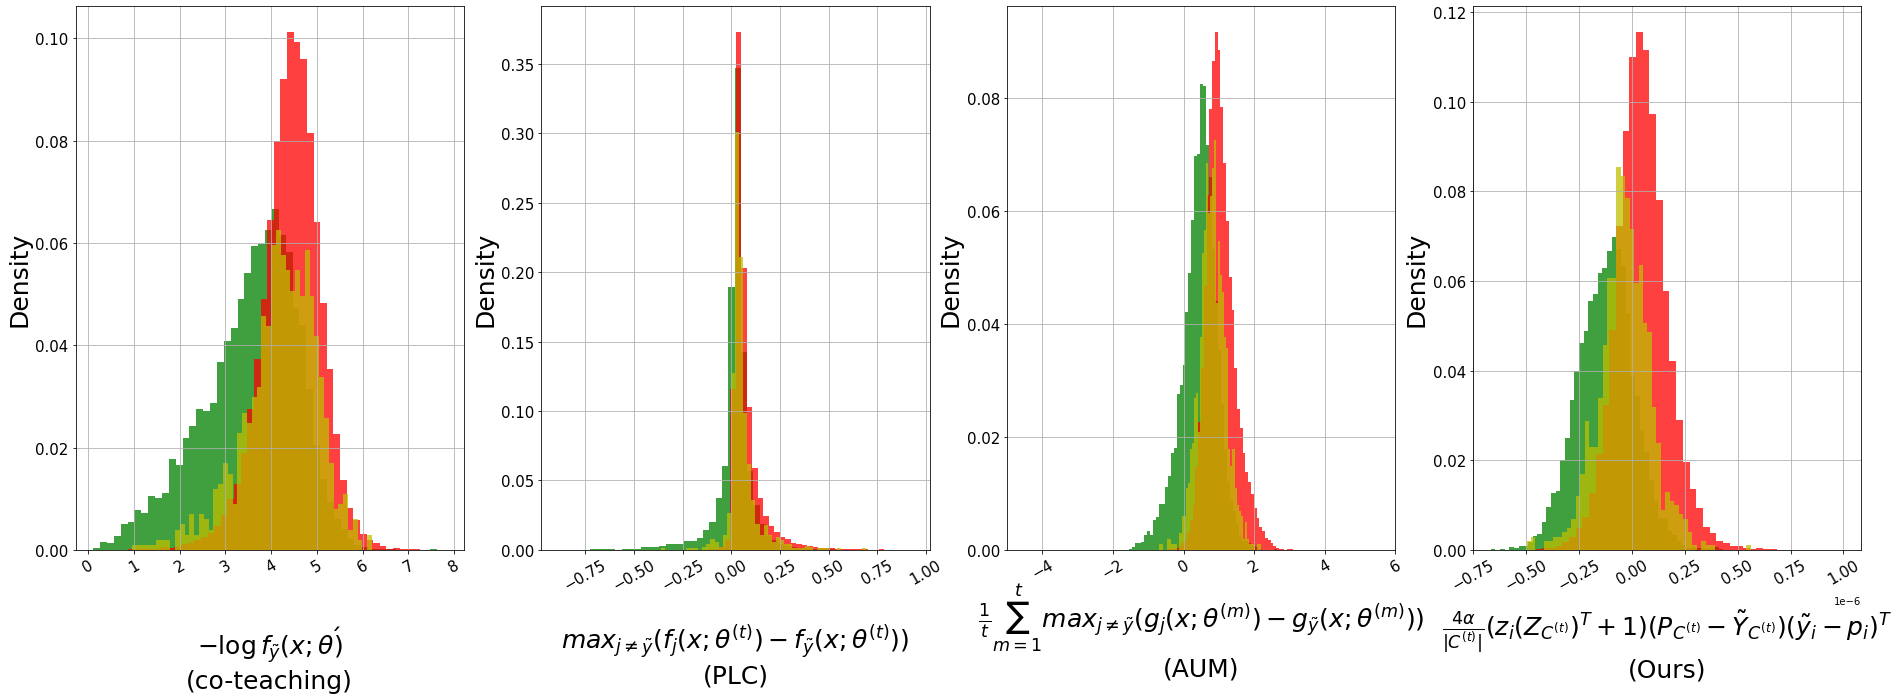

In [12]:
# i = 30

# is_noise_mask = Yt_list[0]!=train_Y
# hard_clean_mask = np.logical_and(hard_mask,~is_noise_mask)
# standard_mask = ~np.logical_or(is_noise_mask,hard_mask)

# rand_mask = np.random.rand(samples)<0.3

# n_n = float(is_noise_mask.sum())
# h_n = float(hard_clean_mask.sum())
# s_n = float(standard_mask.sum())

# plt.figure(figsize=(32,10))

# plt.subplot(1,4,1)
# L_1 = -np.log(Py_temp_list[i])
# plt.hist(L_1[standard_mask],50, label = 'simple clean samples',color='g',alpha=0.75,
# weights=np.ones_like(L_1[standard_mask])/s_n)
# plt.hist(L_1[is_noise_mask]*0.95,50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_1[is_noise_mask])/n_n)
# plt.hist(L_1[hard_clean_mask],50, label = 'hard clean samples',color='y',alpha=0.75,
# weights=np.ones_like(L_1[hard_clean_mask])/h_n)

# plt.xlabel(r'$-\log{f_{\tilde{y}}(x;\theta\')}$'+'\n(co-teaching)',
# fontsize = 25,labelpad = 50)
# # plt.xlim([-5,6])
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)

# # plt.xlim([-0.00025,0.001])
# plt.subplot(1,4,2)
# L_2 = Pm_other_list[i]-Py_temp_list[i]
# plt.hist(L_2[standard_mask],50, label = 'simple clean samples',color = 'g',alpha=0.75,
# weights=np.ones_like(L_2[standard_mask])/s_n)
# plt.hist(L_2[is_noise_mask],50, label = 'noisy samples',color = 'r',alpha=0.75,
# weights=np.ones_like(L_2[is_noise_mask])/n_n)
# plt.hist(L_2[hard_clean_mask],50, label = 'hard clean samples',color = 'y',alpha=0.75,
# weights=np.ones_like(L_2[hard_clean_mask])/h_n)

# plt.xlabel(r'$max_{j \neq \tilde{y}} (f_{j}(x;\theta^{(t)}) - f_{\tilde{y}}(x;\theta^{(t)}))$'+'\n(PLC)',
# fontsize = 25,labelpad = 30)
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False,loc=2)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)

# plt.subplot(1,4,3)
# L_3 = np.zeros((samples,))
# for i_ in range(i):
#     L_3 = L_3 + Logits_other_m_list[i_] - Logits_y_list[i_]
# L_3 /= i
# plt.hist(L_3[standard_mask],50, label = 'simple clean samples',color='g',alpha=0.75,
# weights=np.ones_like(L_3[standard_mask])/s_n)
# plt.hist(L_3[is_noise_mask]*0.9,50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_3[is_noise_mask])/n_n)
# plt.hist(L_3[hard_clean_mask],50, label = 'hard clean samples',color='y',alpha=0.75,
# weights=np.ones_like(L_3[hard_clean_mask])/h_n)

# plt.xlabel(r'$\frac{1}{t}\sum^t_{m=1}{max_{j \neq \tilde{y}} (g_{j}(x;\theta^{(m)})-g_{\tilde{y}}(x;\theta^{(m)}))}$'+'\n(AUM)',
# fontsize = 25,labelpad = -0)
# plt.xlim([-5,6])
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# plt.yticks(fontsize = 15)
# plt.xticks(fontsize = 15,rotation = 30)


# plt.subplot(1,4,4)
# L_4 = learning_risk_list[i]
# plt.hist(L_4[standard_mask],50, label = 'simple clean samples',color = 'g',alpha=0.75,
# weights=np.ones_like(L_4[standard_mask])/s_n)
# plt.hist(L_4[is_noise_mask],50, label = 'noisy samples',color='r',alpha=0.75,
# weights=np.ones_like(L_4[is_noise_mask])/n_n)
# plt.hist(L_4[hard_clean_mask],50, label = 'hard clean samples',color='y', alpha=0.75,
# weights=np.ones_like(L_4[hard_clean_mask])/h_n)

# plt.xlabel(r'$\frac{4\alpha}{|C^{(t)}|}(z_i(Z_{C^{(t)}})^T+1)(P_{C^{(t)}}-\tilde{Y}_{C^{(t)}})(\tilde{y}_i-p_i)^T$'+'\n(Ours)',
# fontsize = 25,labelpad = 15)
# plt.ylabel('Density',fontsize = 25)
# # plt.legend(fontsize=20,frameon=False)
# plt.grid()
# # plt.ticklabel_format(style='plain',)
# plt.yticks(fontsize = 15)
# plt.ticklabel_format(style='sci',axis='x',scilimits = (0,0))
# plt.xticks(fontsize = 15,rotation = 30)

# plt.savefig('Learning_risk_compare_100_uniform.png',dpi = 200, bbox_inches = 'tight')
# plt.savefig('Learning_risk_compare_100_uniform.pdf',dpi = 200, bbox_inches = 'tight')
# plt.show()

/root/miniconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/root/miniconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


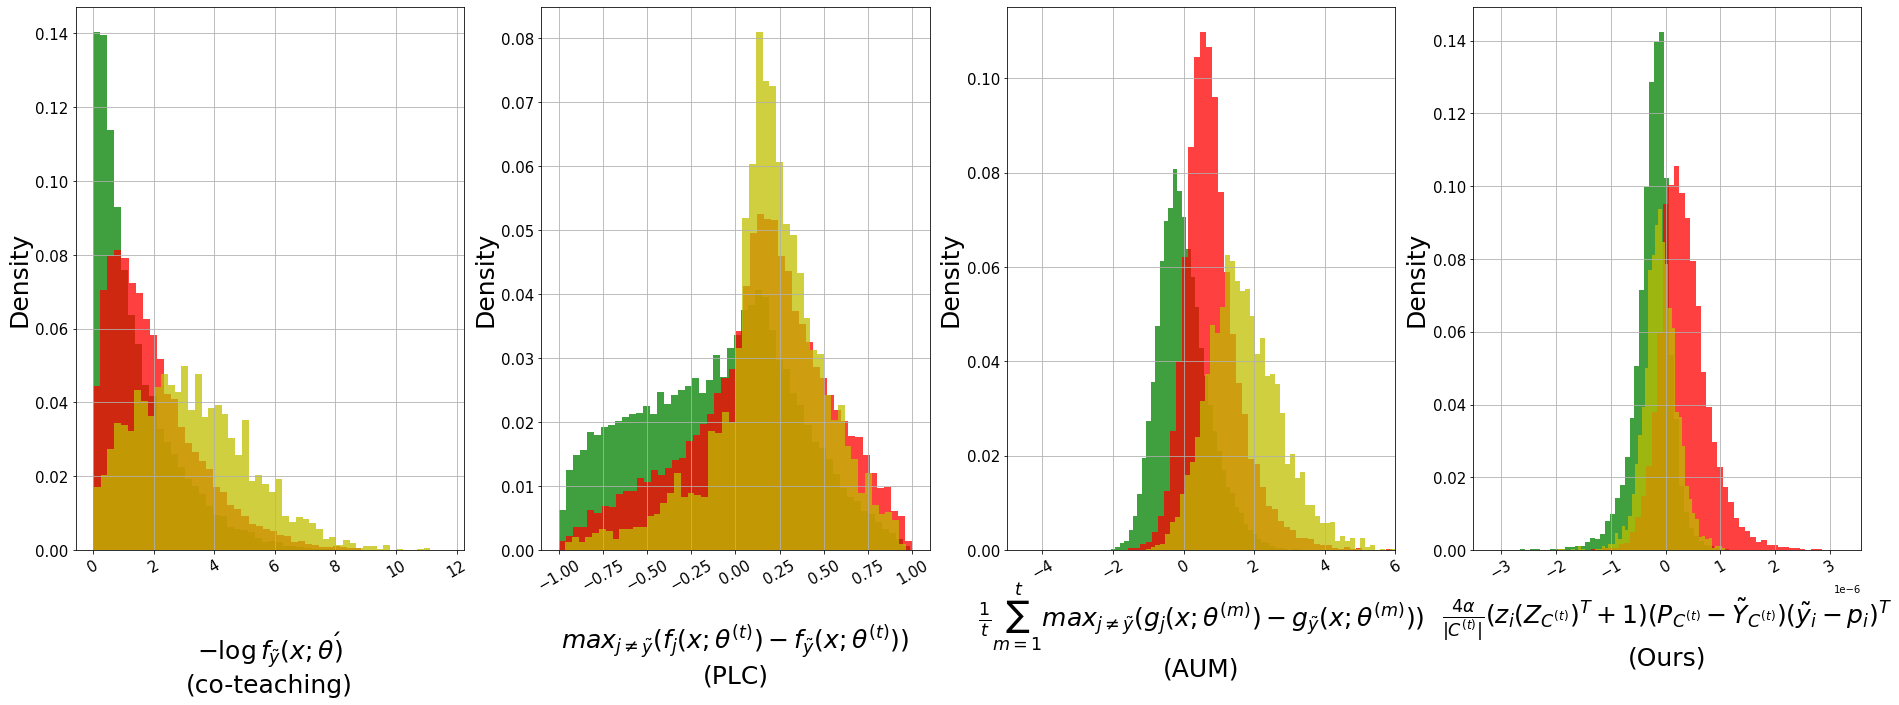

In [12]:
i = 30

is_noise_mask = Yt_list[0]!=train_Y
hard_clean_mask = np.logical_and(hard_mask,~is_noise_mask)
standard_mask = ~np.logical_or(is_noise_mask,hard_mask)

rand_mask = np.random.rand(samples)<0.3

n_n = float(is_noise_mask.sum())
h_n = float(hard_clean_mask.sum())
s_n = float(standard_mask.sum())

plt.figure(figsize=(32,10))

plt.subplot(1,4,1)
L_1 = -np.log(Py_temp_list[i])
plt.hist(L_1[standard_mask],50, label = 'simple clean samples',color='g',alpha=0.75,
weights=np.ones_like(L_1[standard_mask])/s_n)
plt.hist(L_1[is_noise_mask],50, label = 'noisy samples',color='r',alpha=0.75,
weights=np.ones_like(L_1[is_noise_mask])/n_n)
plt.hist(L_1[hard_clean_mask],50, label = 'hard clean samples',color='y',alpha=0.75,
weights=np.ones_like(L_1[hard_clean_mask])/h_n)

plt.xlabel(r'$-\log{f_{\tilde{y}}(x;\theta\')}$'+'\n(co-teaching)',
fontsize = 25,labelpad = 50)
# plt.xlim([-5,6])
plt.ylabel('Density',fontsize = 25)
# plt.legend(fontsize=20,frameon=False)
plt.grid()
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15,rotation = 30)

# plt.xlim([-0.00025,0.001])
plt.subplot(1,4,2)
L_2 = Pm_other_list[i]-Py_temp_list[i]
plt.hist(L_2[standard_mask],50, label = 'simple clean samples',color = 'g',alpha=0.75,
weights=np.ones_like(L_2[standard_mask])/s_n)
plt.hist(L_2[is_noise_mask],50, label = 'noisy samples',color = 'r',alpha=0.75,
weights=np.ones_like(L_2[is_noise_mask])/n_n)
plt.hist(L_2[hard_clean_mask],50, label = 'hard clean samples',color = 'y',alpha=0.75,
weights=np.ones_like(L_2[hard_clean_mask])/h_n)

plt.xlabel(r'$max_{j \neq \tilde{y}} (f_{j}(x;\theta^{(t)}) - f_{\tilde{y}}(x;\theta^{(t)}))$'+'\n(PLC)',
fontsize = 25,labelpad = 30)
plt.ylabel('Density',fontsize = 25)
# plt.legend(fontsize=20,frameon=False,loc=2)
plt.grid()
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15,rotation = 30)

plt.subplot(1,4,3)
L_3 = np.zeros((samples,))
for i_ in range(i):
    L_3 = L_3 + Logits_other_m_list[i_] - Logits_y_list[i_]
L_3 /= i
plt.hist(L_3[standard_mask],50, label = 'simple clean samples',color='g',alpha=0.75,
weights=np.ones_like(L_3[standard_mask])/s_n)
plt.hist(L_3[is_noise_mask],50, label = 'noisy samples',color='r',alpha=0.75,
weights=np.ones_like(L_3[is_noise_mask])/n_n)
plt.hist(L_3[hard_clean_mask],50, label = 'hard clean samples',color='y',alpha=0.75,
weights=np.ones_like(L_3[hard_clean_mask])/h_n)

plt.xlabel(r'$\frac{1}{t}\sum^t_{m=1}{max_{j \neq \tilde{y}} (g_{j}(x;\theta^{(m)})-g_{\tilde{y}}(x;\theta^{(m)}))}$'+'\n(AUM)',
fontsize = 25,labelpad = -0)
plt.xlim([-5,6])
plt.ylabel('Density',fontsize = 25)
# plt.legend(fontsize=20,frameon=False)
plt.grid()
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15,rotation = 30)


plt.subplot(1,4,4)
L_4 = learning_risk_list[i]
plt.hist(L_4[standard_mask],50, label = 'simple clean samples',color = 'g',alpha=0.75,
weights=np.ones_like(L_4[standard_mask])/s_n)
plt.hist(L_4[is_noise_mask],50, label = 'noisy samples',color='r',alpha=0.75,
weights=np.ones_like(L_4[is_noise_mask])/n_n)
plt.hist(L_4[hard_clean_mask],50, label = 'hard clean samples',color='y', alpha=0.75,
weights=np.ones_like(L_4[hard_clean_mask])/h_n)

plt.xlabel(r'$\frac{4\alpha}{|C^{(t)}|}(z_i(Z_{C^{(t)}})^T+1)(P_{C^{(t)}}-\tilde{Y}_{C^{(t)}})(\tilde{y}_i-p_i)^T$'+'\n(Ours)',
fontsize = 25,labelpad = 15)
plt.ylabel('Density',fontsize = 25)
# plt.legend(fontsize=20,frameon=False)
plt.grid()
# plt.ticklabel_format(style='plain',)
plt.yticks(fontsize = 15)
plt.ticklabel_format(style='sci',axis='x',scilimits = (0,0))
plt.xticks(fontsize = 15,rotation = 30)

plt.savefig('Learning_risk_compare_100_pair.png',dpi = 200, bbox_inches = 'tight')
plt.savefig('Learning_risk_compare_100_pair.pdf',dpi = 200, bbox_inches = 'tight')
plt.show()